#**MULTICOLLINEARITY**

This notebook is designed to analyze multicollinearity in economic data, using various financial variables such as GDP growth, interest rates, inflation, unemployment rates, and stock market returns, including KO stock data.

In [1]:
##pip install fredapi
!pip install fredapi

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from datetime import datetime
from yfinance import download
from statsmodels.tools.tools import add_constant
import numpy as np


In [3]:
# FRED API Key (Replace with your actual key)
fred = Fred(api_key='cc42bf6cb567e9a844997c88250f49fe')

# Extracting relevant series
gdp_growth = fred.get_series('GDP')
interest_rate = fred.get_series('DFF')
inflation = fred.get_series('CPIAUCSL')
unemployment_rate = fred.get_series('UNRATE')
stock_market_returns = fred.get_series('SP500')

In [4]:
# Checking the date ranges
print("GDP Growth Date Range:", gdp_growth.index.min(), "to", gdp_growth.index.max())
print("Interest Rate Date Range:", interest_rate.index.min(), "to", interest_rate.index.max())
print("Inflation Date Range:", inflation.index.min(), "to", inflation.index.max())
print("Unemployment Rate Date Range:", unemployment_rate.index.min(), "to", unemployment_rate.index.max())
print("Stock Market Returns Date Range:", stock_market_returns.index.min(), "to", stock_market_returns.index.max())


GDP Growth Date Range: 1946-01-01 00:00:00 to 2024-04-01 00:00:00
Interest Rate Date Range: 1954-07-01 00:00:00 to 2024-08-27 00:00:00
Inflation Date Range: 1947-01-01 00:00:00 to 2024-07-01 00:00:00
Unemployment Rate Date Range: 1948-01-01 00:00:00 to 2024-07-01 00:00:00
Stock Market Returns Date Range: 2014-08-29 00:00:00 to 2024-08-28 00:00:00


 The notebook includes code to fetch real-world data from sources like FRED and Yahoo Finance. For example, it retrieves KO stock data from 2015 to the present to calculate excess returns and other variables.

In [5]:
# Fetching stock data from Yahoo Finance
ko_data = download('KO', start='2015-01-01', end=datetime.now().strftime('%Y-%m-%d'))
pepsi_data = download('PEP', start='2015-01-01', end=datetime.now().strftime('%Y-%m-%d'))
pepsi_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,94.930000,95.339996,94.050003,94.440002,71.740646,3545700
2015-01-05,94.449997,95.050003,93.720001,93.730003,71.201271,6441000
2015-01-06,94.080002,94.620003,92.940002,93.019997,70.661934,6195000
2015-01-07,95.129997,96.230003,94.430000,95.739998,72.728134,6526300
2015-01-08,96.739998,97.910004,96.680000,97.480003,74.049927,7131600
...,...,...,...,...,...,...
2024-08-22,175.830002,176.080002,174.699997,175.740005,175.740005,5265900
2024-08-23,176.630005,176.679993,173.669998,175.869995,175.869995,5283600
2024-08-26,176.320007,176.839996,175.729996,175.970001,175.970001,4146700


In [6]:
# Calculate quarterly excess returns
ko_quarterly_close = ko_data['Adj Close'].resample('Q').last().pct_change().dropna()
ko_quarterly_open = ko_data['Open'].resample('Q').last().pct_change().dropna()
pepsi_quarterly_close = pepsi_data['Adj Close'].resample('Q').last().pct_change().dropna()
pepsi_quarterly_open = pepsi_data['Open'].resample('Q').last().pct_change().dropna()


# Resample all series to quarterly frequency
gdp_growth = gdp_growth.resample('Q').last().pct_change().dropna()
interest_rate = interest_rate.resample('Q').mean()
inflation = inflation.resample('Q').last().pct_change().dropna()
unemployment_rate = unemployment_rate.resample('Q').mean()
stock_market_returns = stock_market_returns.resample('Q').last().pct_change().dropna()

# Align all data into a single DataFrame
data = pd.DataFrame({
    'KO_Q_EX_R_close': ko_quarterly_close,
    'KO_Q_EX_R_open': ko_quarterly_open,
    'Pepsi_Q_EX_R_close': pepsi_quarterly_close,
    'Pepsi_Q_EX_R_open': pepsi_quarterly_open,
    'Interest_Rate': interest_rate,
    'Inflation': inflation,
    'Unemployment_Rate': unemployment_rate,
    'Stock_Market_Returns': stock_market_returns
}).dropna()

# Ensure alignment of the data starting from the latest common date (2014-08-27)
data = data[data.index >= '2014-08-27']

# Filtering data for the past 5 years
current_date = datetime.now()
five_years_ago = current_date - pd.DateOffset(years=5)
data = data[data.index >= five_years_ago]

# Display the DataFrame after filtering
print("Data after filtering:")
data.head()

Data after filtering:


,KO_Q_EX_R_close,KO_Q_EX_R_open,Pepsi_Q_EX_R_close,Pepsi_Q_EX_R_open,Interest_Rate,Inflation,Unemployment_Rate,Stock_Market_Returns
2019-09-30,0.076945,0.056173,0.052753,0.028651,2.192174,0.004769,3.600000,0.011891
2019-12-31,0.024310,0.019391,0.003846,0.004556,1.645652,0.008579,3.600000,0.085342
2020-03-31,-0.193531,-0.183515,-0.115308,-0.085961,1.254945,-0.001856,3.833333,-0.200011
2020-06-30,0.018891,-0.018194,0.109797,0.055146,0.058791,-0.004439,13.000000,0.199529
2020-09-30,0.113913,0.113446,0.055471,0.046727,0.092609,0.011467,8.800000,0.084737


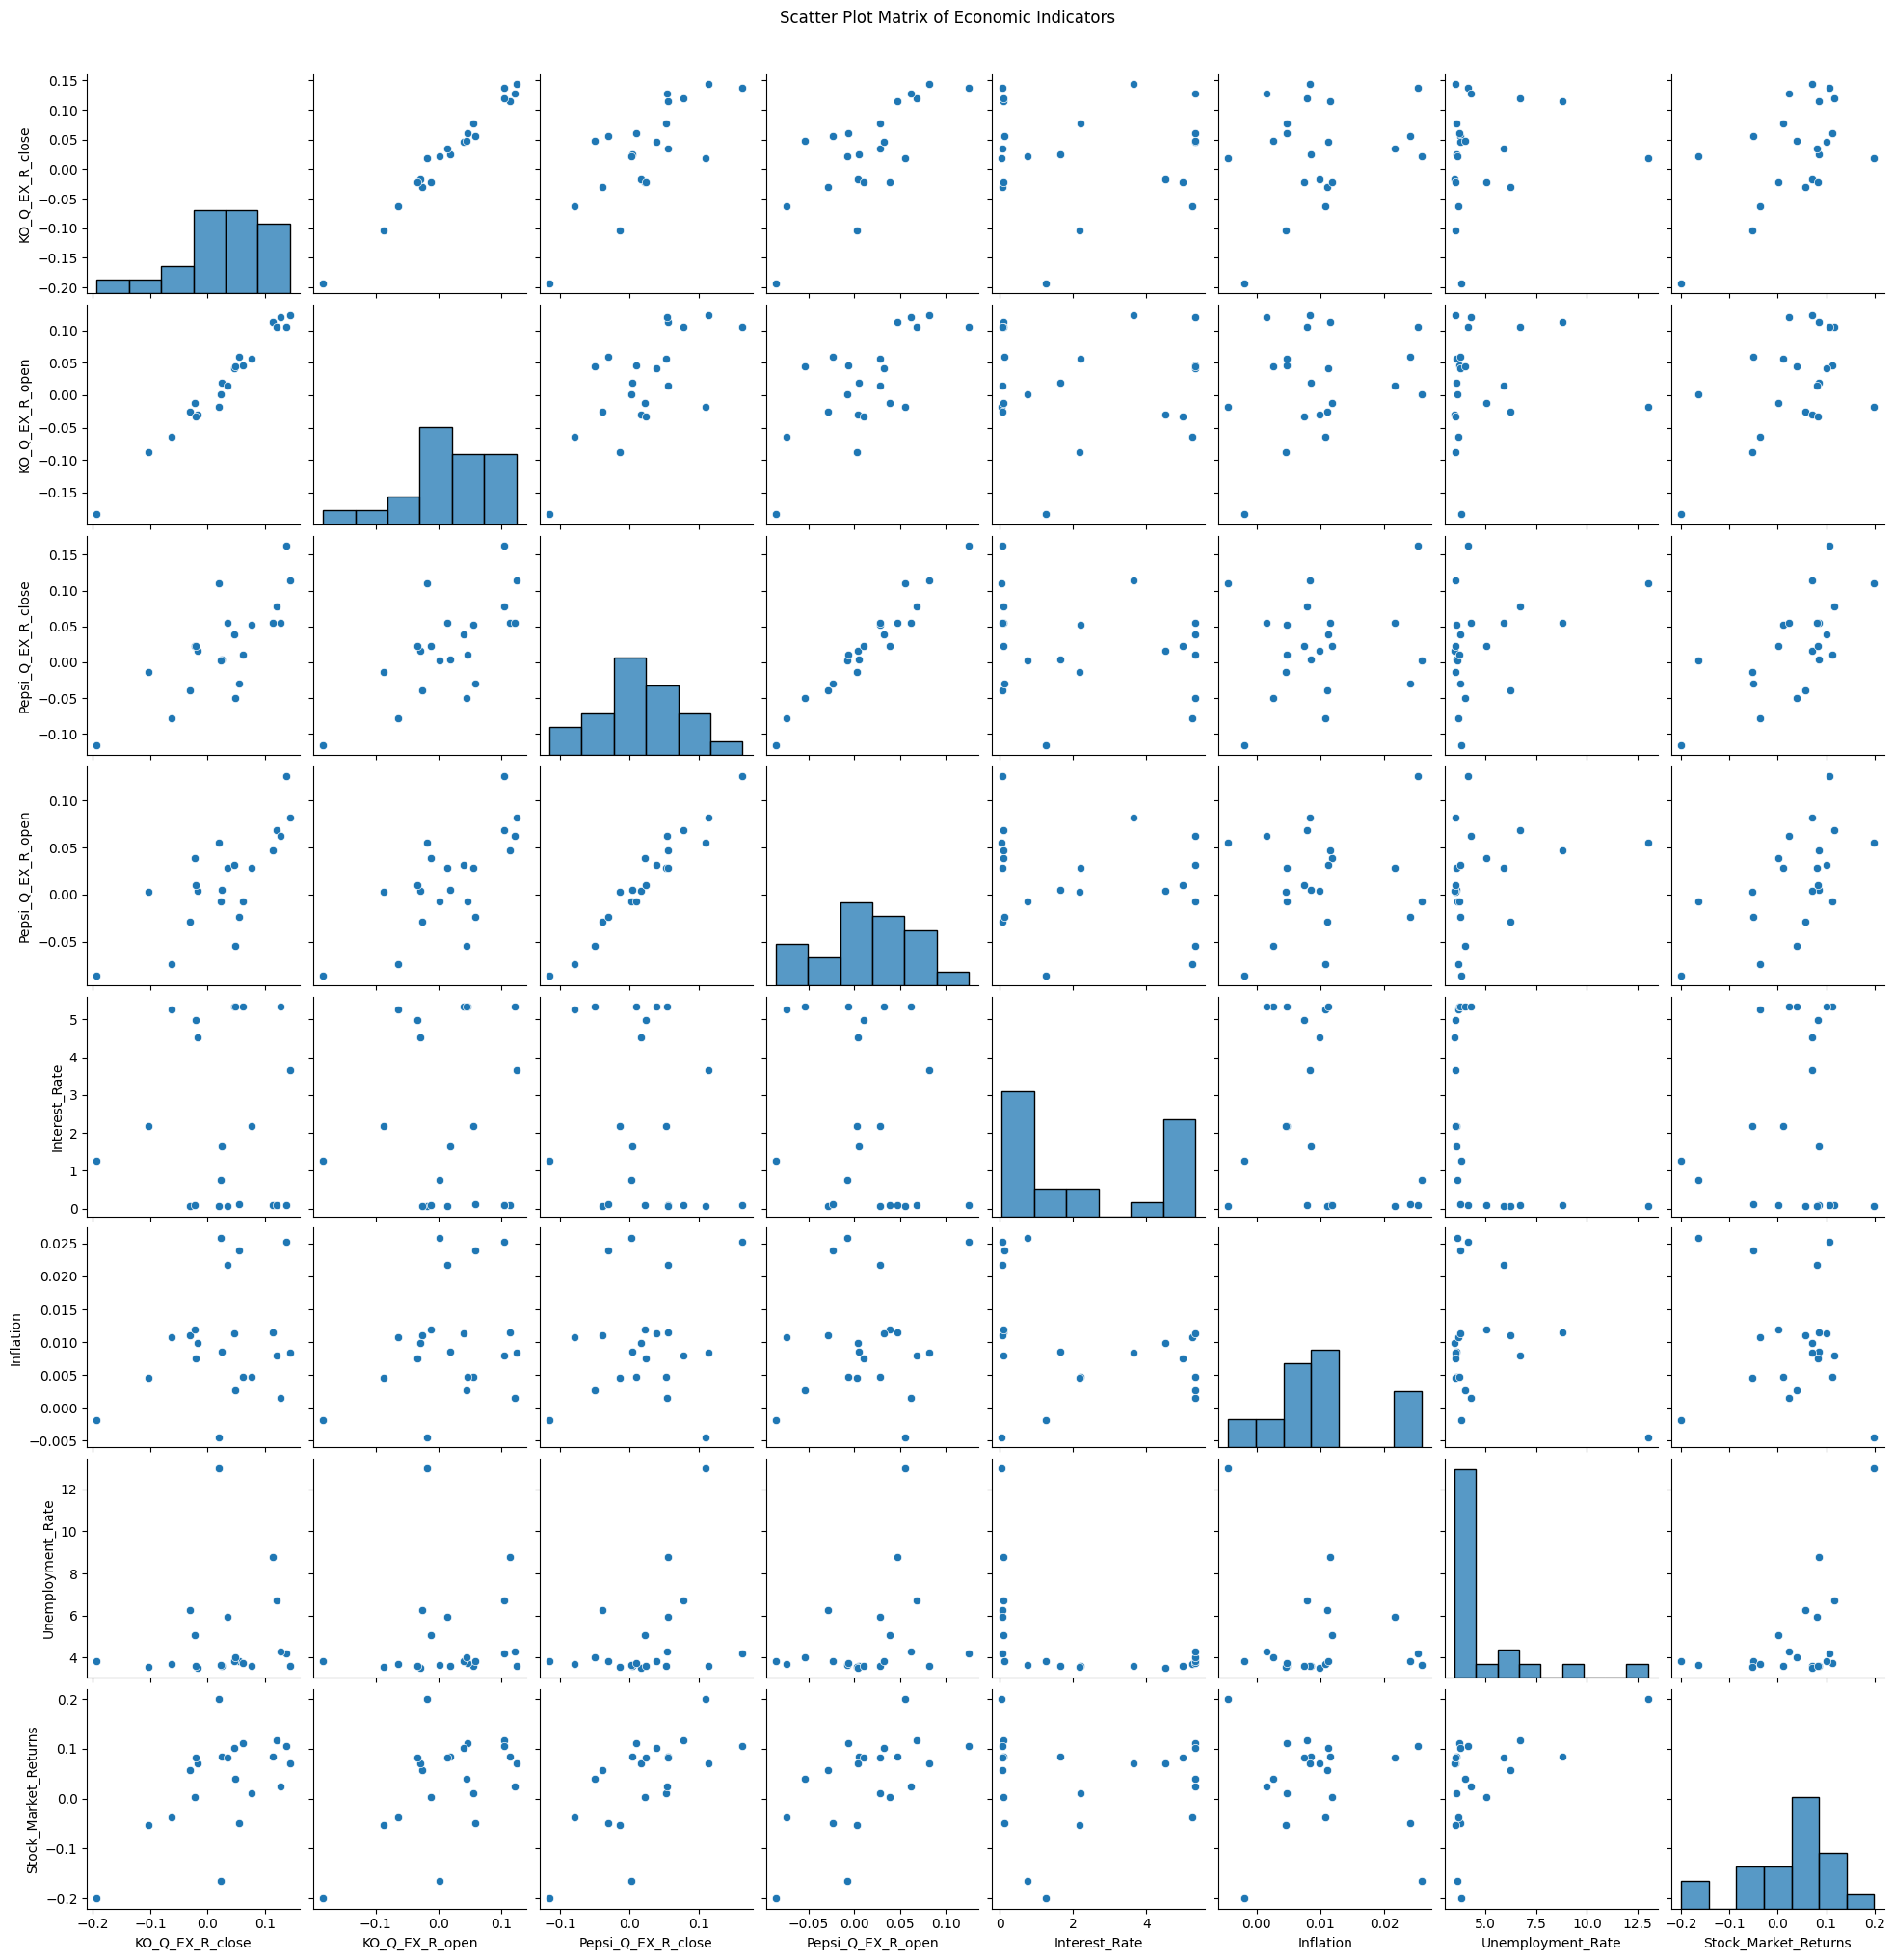

In [7]:
# Pair plot to visualize relationships between variables
sns.pairplot(data)
plt.suptitle('Scatter Plot Matrix of Economic Indicators', y=1.02)
plt.show()


The notebook could generate correlation matrices or VIF (Variance Inflation Factor) plots to visually represent multicollinearity among the variables. The data used in the plots would be the same as the above KO stock data and other economic indicators.

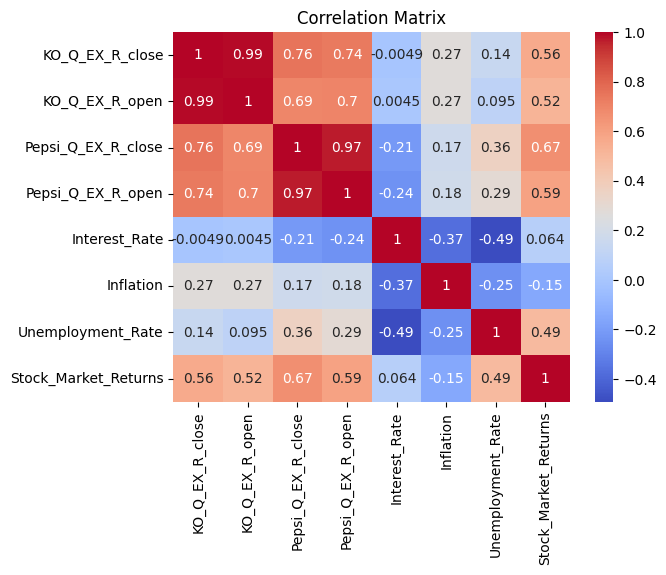

In [8]:
# Correlation matrix and heatmap
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Multicollinearity is diagnosed by calculating the Variance Inflation Factor (VIF) for each independent variable. A VIF value greater than 10 typically indicates significant multicollinearity.

In [9]:
# Calculate Variance Inflation Factor (VIF)
features = add_constant(data.drop(columns=['KO_Q_EX_R_close']))
vif_data = pd.DataFrame()
vif_data['feature'] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

vif_data


,feature,VIF
0,const,44.595197
1,KO_Q_EX_R_open,2.467614
2,Pepsi_Q_EX_R_close,25.737410
3,Pepsi_Q_EX_R_open,23.925968
4,Interest_Rate,3.293688
5,Inflation,2.240524
6,Unemployment_Rate,3.627529
7,Stock_Market_Returns,3.018799


Multicollinearity can distort the estimation of regression coefficients, making it difficult to determine the individual effect of each independent variable. It can lead to inflated standard errors, reducing the statistical power of the analysis.

<ipython-input-10-1111a4f1485c>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefs, x='Feature', y='Coefficient', palette='viridis')


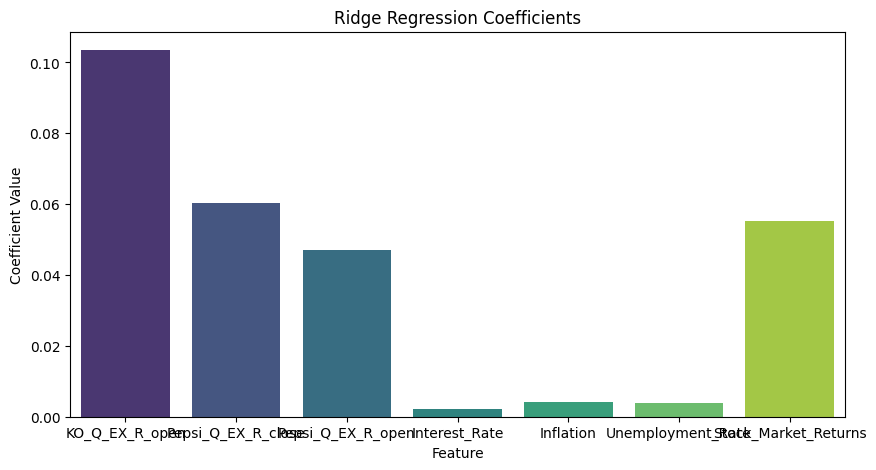

In [10]:
from sklearn.linear_model import Ridge

# Split data into features and target
X = data.drop("KO_Q_EX_R_close", axis=1)
y = data["KO_Q_EX_R_close"]

# Implement Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)

# Visualize coefficients
coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge.coef_
})

plt.figure(figsize=(10, 5))
sns.barplot(data=coefs, x='Feature', y='Coefficient', palette='viridis')
plt.title('Ridge Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.show()

# **SENSITIVITY TO OUTLIERS**

## Demonstration

In [11]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from statsmodels.graphics.regressionplots import abline_plot
import scipy.stats as stats
from scipy.stats import kurtosis, skewnorm
from scipy.stats import iqr
from pandas.core.common import random_state
from sklearn.linear_model import LinearRegression

plt.rcParams["figure.figsize"] = (10, 7)

In [21]:
# Download the dataset")
data = pd.read_csv("../Japan (Export vs GDP).csv")

In [22]:
data.head()

,Date,GDP,EXP
0,10/1/2023,558760.9,6276.5
1,4/1/2023,564406.4,5679.1
2,7/1/2023,558676.3,5073.6
3,1/1/2024,554727.9,4006.1
4,1/1/2021,541081.4,2031.3


## Diagram

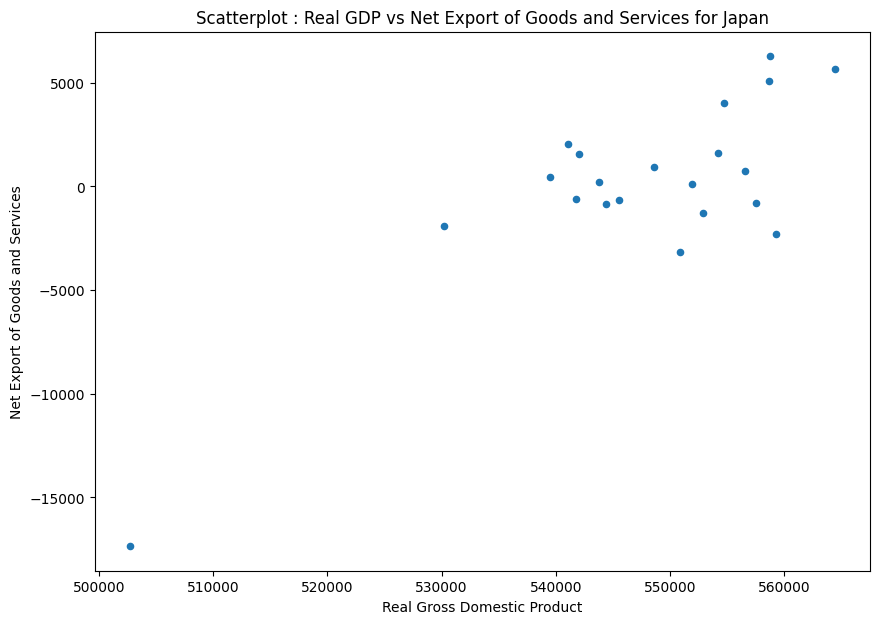

In [23]:
# Create scatter plot
scatt = data.plot.scatter(
    x="GDP",
    y="EXP",
    title="Scatterplot : Real GDP vs Net Export of Goods and Services for Japan",
)
scatt.set(xlabel="Real Gross Domestic Product", ylabel="Net Export of Goods and Services")
plt.show()

## Diagnosis

To diagnose the challenge, the Cook's distance will be used to further proof the presence of outliers in the dataset.

In [25]:
# Linear regression result - dataset
model_1 = smf.ols(
    "EXP ~ GDP", data=data
).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    EXP   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     34.88
Date:                Thu, 29 Aug 2024   Prob (F-statistic):           1.10e-05
Time:                        20:06:05   Log-Likelihood:                -196.05
No. Observations:                  21   AIC:                             396.1
Df Residuals:                      19   BIC:                             398.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.572e+05   2.66e+04     -5.904      0.000   -2.13e+05   -1.01e+05
GDP            0.2870      0.049      5.906      0.000       0.185       0.389
==============================================================================
Omnibus:                        1.969   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.374   Jarque-Bera (JB):                1.563
Skew:                          -0.515   Prob(JB):                        0.458
Kurtosis:                       2.149   Cond. No.                     2.32e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Cook's Distance

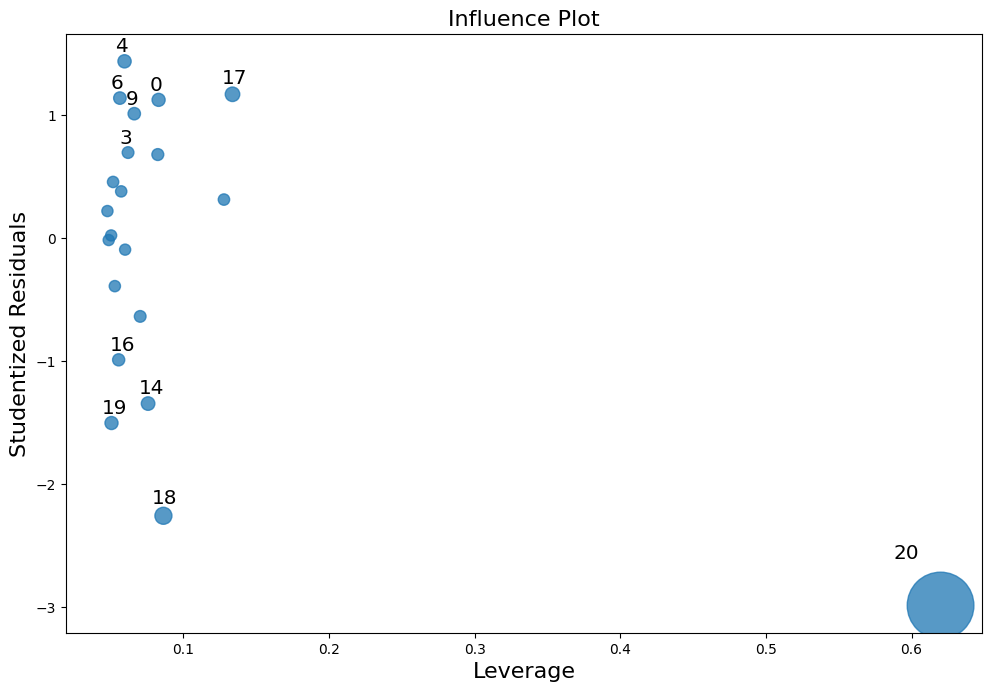

In [26]:
# Influence plot
fig = sm.graphics.influence_plot(model_1, criterion="cooks", alpha=0.5)
fig.tight_layout(pad=1.0)

In [27]:
# Finding most influential points
influence = model_1.get_influence()
inf_sum = influence.summary_frame().sort_values("cooks_d", ascending=False)
inf_sum

,dfb_Intercept,dfb_GDP,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
20,-3.690000,3.666027,5.136157,-2.509791,0.619883,-3.205045,-2.987829,-3.815508
18,0.452681,-0.464998,0.198245,-2.048192,0.086351,-0.629674,-2.258416,-0.694303
17,0.374781,-0.368410,0.103385,1.157055,0.133784,0.454719,1.168099,0.459059
14,0.227899,-0.235188,0.071298,-1.318310,0.075827,-0.377618,-1.346193,-0.385605
4,0.170132,-0.162539,0.061962,1.397512,0.059666,0.352027,1.436046,0.361734
19,0.077864,-0.085852,0.056674,-1.456652,0.050711,-0.336673,-1.504283,-0.347682
0,-0.214559,0.220669,0.056305,1.115106,0.083042,0.335576,1.122724,0.337868
6,0.116086,-0.110078,0.038102,1.128489,0.056460,0.276051,1.137161,0.278172
9,0.148418,-0.143064,0.036227,1.009825,0.066338,0.269173,1.010379,0.269321
16,0.085930,-0.091213,0.028928,-0.991076,0.055626,-0.240533,-0.990588,-0.240414


The 20th (last) point has the highest influence on the model

## Damage

### Descriptive Statistics

In [28]:
data.describe()

,GDP,EXP
count,21.000000,21.000000
mean,547593.676190,-7.209524
std,13267.455668,4732.427934
min,502708.700000,-17350.300000
25%,542014.600000,-856.000000
50%,550893.000000,198.300000
75%,556550.600000,1620.200000
max,564406.400000,6276.500000


In [29]:
# drop outlier
#data2 : dataset without outlier
data2 = data.drop(data[data['EXP'] == -17350.3].index)
data2.describe()

,GDP,EXP
count,20.000000,20.000000
mean,549837.925000,859.945000
std,8599.612769,2636.739977
min,530176.900000,-3152.500000
25%,543322.825000,-815.125000
50%,551420.550000,337.400000
75%,556802.675000,1722.975000
max,564406.400000,6276.500000


#### Influence on Common Statistics Measures

In [30]:
# Mean and Range of Original Dataset
print("Mean with outlier :",  data.EXP.mean())
print ("Range with outlier:", data["EXP"].max() - data["EXP"].min())

Mean with outlier : -7.209523809523706
Range with outlier: 23626.8


In [31]:
# Mean and Range of Dataset Without Outlier
print("Mean without outlier :",  data2.EXP.mean())
print ("Range without outlier:", data2["EXP"].max() - data2["EXP"].min())

Mean without outlier : 859.945
Range without outlier: 9429.0


Mean and Range for both original dataset and the dataset without outliers shows significant difference

### Regression Analysis

#### Linear Regression - With Outliers

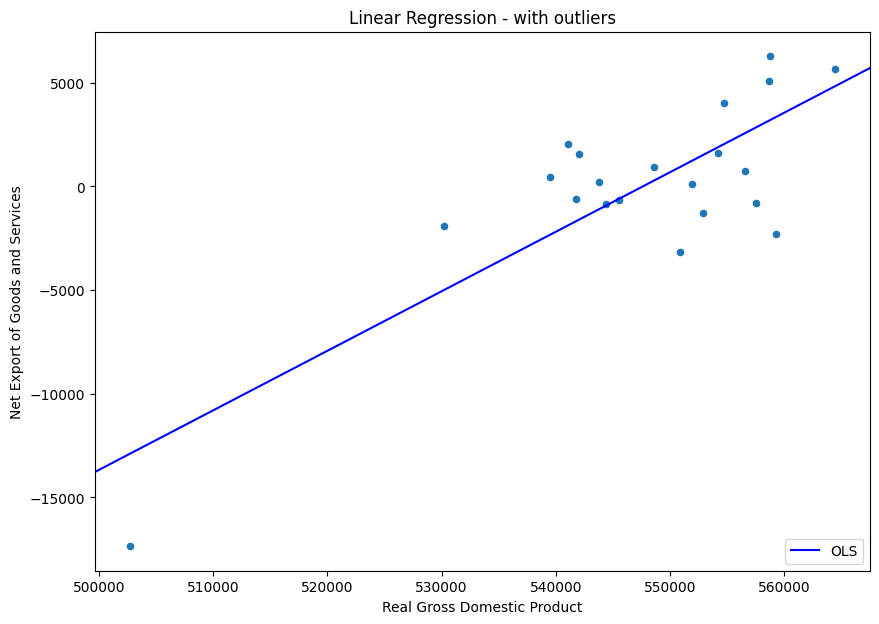

In [32]:
# Create regression model - with outliers
scatt = data.plot(x="GDP", y="EXP", kind="scatter",title="Linear Regression - with outliers")
scatt.set(xlabel="Real Gross Domestic Product", ylabel="Net Export of Goods and Services")
abline_plot(model_results=model_1, ax=scatt, color="blue", label="OLS")
plt.legend(loc="lower right")
plt.show()

#### Linear Regression - Without Outliers

In [33]:
# Regression model results - without outliers
model_without_outliers = smf.ols(
    "EXP ~ GDP", data=data2
).fit()
model_without_outliers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    EXP   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     4.518
Date:                Thu, 29 Aug 2024   Prob (F-statistic):             0.0476
Time:                        20:24:53   Log-Likelihood:                -183.17
No. Observations:                  20   AIC:                             370.3
Df Residuals:                      18   BIC:                             372.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.465e+04   3.55e+04     -2.101      0.050   -1.49e+05      -6.628
GDP            0.1373      0.065      2.126      0.048       0.002       0.273
==============================================================================
Omnibus:                        0.249   Durbin-Watson:                   0.523
Prob(Omnibus):                  0.883   Jarque-Bera (JB):                0.424
Skew:                          -0.176   Prob(JB):                        0.809
Kurtosis:                       2.379   Cond. No.                     3.61e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

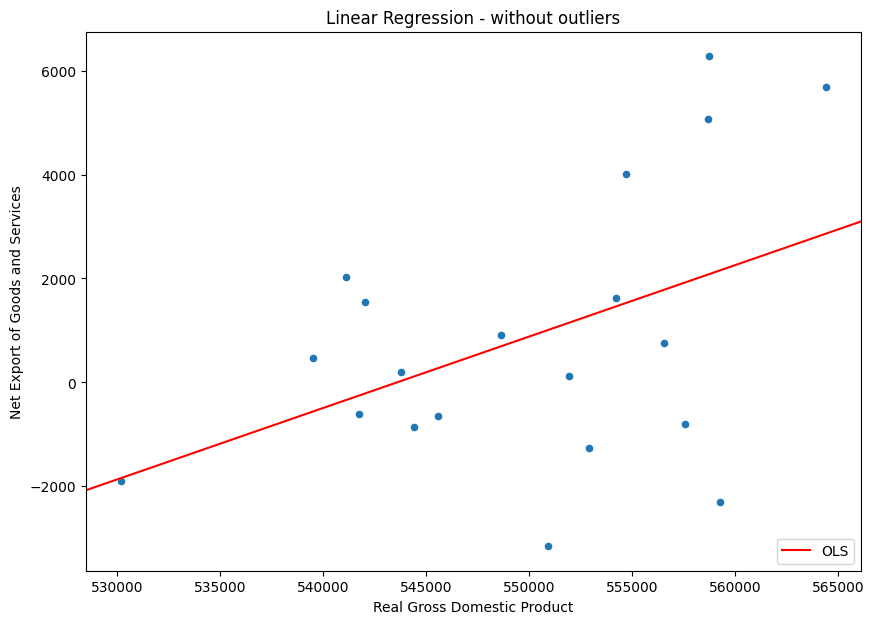

In [34]:
# Regression model - without outliers
scatt = data2.plot(x="GDP", y="EXP", kind="scatter",title="Linear Regression - without outliers")
scatt.set(xlabel="Real Gross Domestic Product", ylabel="Net Export of Goods and Services")
abline_plot(model_results=model_without_outliers, ax=scatt, color="red", label="OLS")
plt.legend(loc="lower right")
plt.show()

The linear regression model of the original dataset (with outlier) is less skewed compared to the model without outliers. Coefficients for both models are also different.

## Directions

### Robust Measures

Handling outliers may require the use of robust measures. In econometrics, some of the summary statistics, such as median and interquartile range, are robust to outliers and provide a sense of direction as to the accurate deductions from the data.

In [35]:
# Mean and IQR without outlier
print("Median without outlier :",  data2.EXP.median())
print ("Interquartile Range without outlier:", iqr(data2["EXP"]))

Median without outlier : 337.4
Interquartile Range without outlier: 2538.1


In [36]:
# Mean and IQR with outlier
print("Median with outlier :",  data.EXP.median())
print ("Interquartile Range with outlier:", iqr(data["EXP"]))

Median with outlier : 198.3
Interquartile Range with outlier: 2476.2


Interquartile range is a better robust measure for handling outliers

### Robust Regression


On the other hand, there are relevant models that can handle the challenge of outlier sensitivity. Some of them include: Weighted Least Squares Regression and M-estimation methods like the Huber and Bisquare methods. Essentially, these models handle outliers by assigning the lowest weights to outliers and higher weights to the nearest data points to the regression line.

To better optimise these model solutions, one must compare the estimated weights obtained by each of these respective models before selecting the best regression fit.

Therefore, 4 regression models (OLS, WLS, Huber & Bisquare) will be run, and the best models selected based on the results for the estimated weights as well as other statistical criteria.

#### Weighted Least Squares - Impact of Japan GDP on Net Exports of Goods

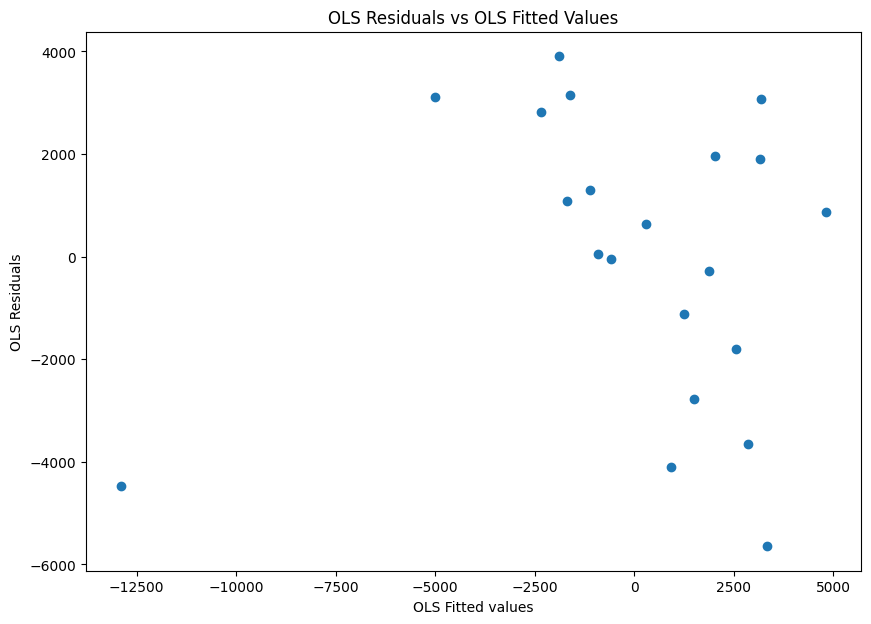

In [43]:
# Scatter Plot for OLS Fitted Values and OLS Residuals

# Fitted values and residuals
model_fitted_y = model_1.fittedvalues
model_resid_y = model_1.resid

# Plot
plt.scatter(x=model_fitted_y, y=model_resid_y)
plt.title("OLS Residuals vs OLS Fitted Values")
plt.xlabel("OLS Fitted values")
plt.ylabel("OLS Residuals")
plt.show()

In [37]:
# WLS model

# Add Absolute residuals and fitted values to dataset columns
data["abs_residuals"] = np.abs(model_1.resid)
data["fitted_values"] = model_1.fittedvalues

# Fit OLS model with absolute residuals and fitted values
model_temp = smf.ols("abs_residuals ~ fitted_values", data=data).fit()

# Compute weights and add it to the data_set column
weights = model_temp.fittedvalues
weights = weights**-2
data["weights"] = weights

# Fit WLS model
Y = data["EXP"].tolist()
X = data["GDP"].tolist()
X = sm.add_constant(X)  # add a intercept point

model_WLS = sm.WLS(Y, X, data["weights"]).fit()
model_WLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.484
Model:                            WLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     17.84
Date:                Thu, 29 Aug 2024   Prob (F-statistic):           0.000460
Time:                        20:38:57   Log-Likelihood:                -195.87
No. Observations:                  21   AIC:                             395.7
Df Residuals:                      19   BIC:                             397.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.359e+05   3.24e+04     -4.200      0.000   -2.04e+05   -6.82e+04
x1             0.2482      0.059      4.223      0.000       0.125       0.371
==============================================================================
Omnibus:                        1.925   Durbin-Watson:                   1.168
Prob(Omnibus):                  0.382   Jarque-Bera (JB):                1.637
Skew:                          -0.590   Prob(JB):                        0.441
Kurtosis:                       2.309   Cond. No.                     2.90e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

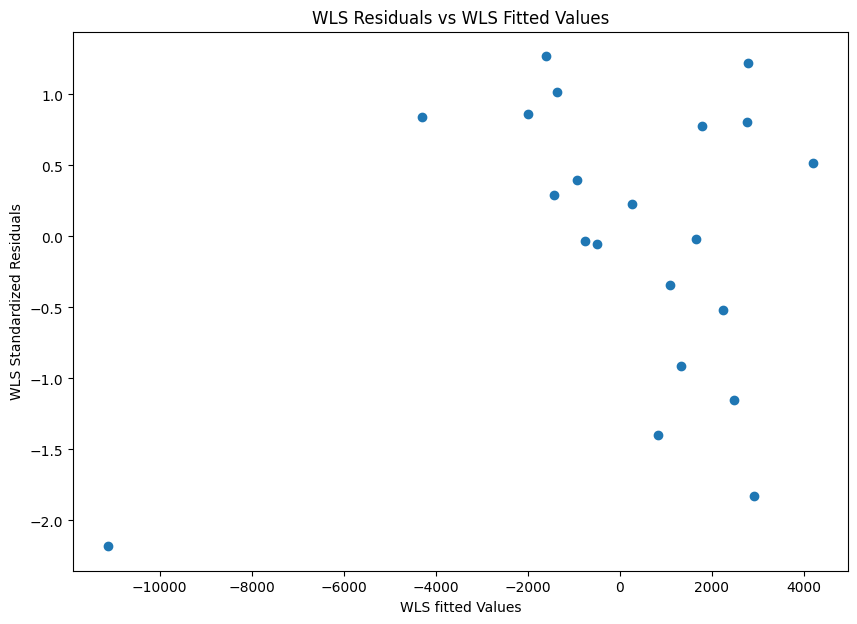

In [38]:
# WLS fitted values and standardized residuals
fitted_valuesWLS = model_WLS.fittedvalues
model_residWLS = model_WLS.resid
std_model_residWLS = model_residWLS / model_residWLS.std(ddof=1)

# Plot WLS fitted v. vs standardized res. scatterplot
plt.scatter(fitted_valuesWLS, std_model_residWLS)
plt.xlabel("WLS fitted Values")
plt.ylabel("WLS Standardized Residuals")
plt.title("WLS Residuals vs WLS Fitted Values")
plt.show()

#### Huber Method - Impact of Japan's GDP on Net Exports of Goods

In [40]:
# Huber model
rr_huber = sm.RLM(
    data["EXP"], sm.add_constant(data["GDP"]), M=sm.robust.norms.HuberT()
)
rr_huber_results = rr_huber.fit()
rr_huber_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                    EXP   No. Observations:                   21
Model:                            RLM   Df Residuals:                       19
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 29 Aug 2024                                         
Time:                        20:42:37                                         
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.526e+05   2.82e+04     -5.412      0.000   -2.08e+05   -9.73e+04
GDP            0.2789      0.051      5.419      0.000       0.178       0.380
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

#### Bisquare Method - Impact of Japan's GDP on Net Exports of Goods

In [41]:
# Bisquare Method model
rr_bisquare = sm.RLM(
    data["EXP"],
    sm.add_constant(data["GDP"]),
    M=sm.robust.norms.TukeyBiweight(),
)
rr_bisquare_results = rr_bisquare.fit()
rr_bisquare_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                    EXP   No. Observations:                   21
Model:                            RLM   Df Residuals:                       19
Method:                          IRLS   Df Model:                            1
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 29 Aug 2024                                         
Time:                        20:42:55                                         
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.558e+05    2.9e+04     -5.365      0.000   -2.13e+05   -9.89e+04
GDP            0.2848      0.053      5.371      0.000       0.181       0.389
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

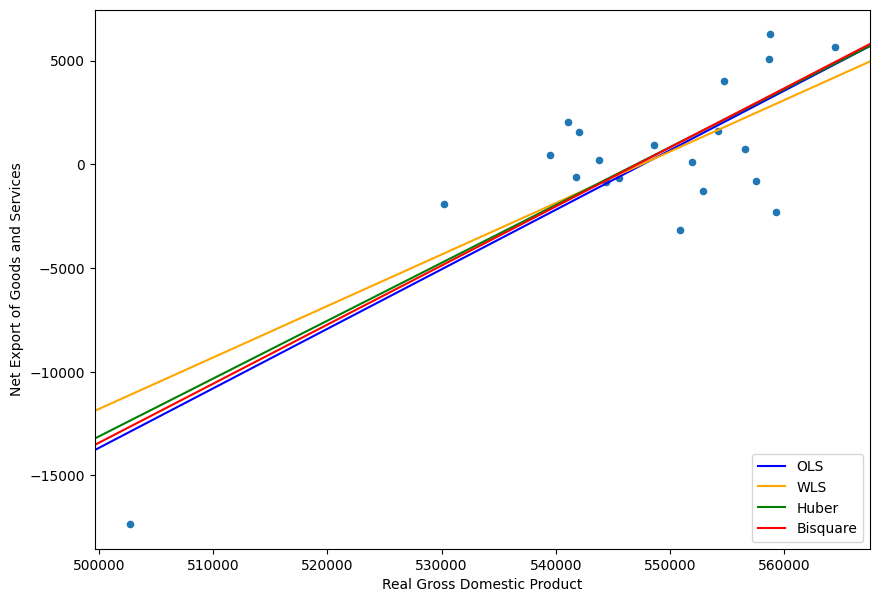

In [42]:
# Scatter Plot of Japan's Net Export of Goods and Services and Gross Domestic Product with Different Regression Lines

# scatter-plot data
scatt = data.plot(x="GDP", y="EXP", kind="scatter")
scatt.set(xlabel="Real Gross Domestic Product", ylabel="Net Export of Goods and Services")

# plot regression lines
abline_plot(model_results=model_1, ax=scatt, color="blue", label="OLS")
abline_plot(model_results=model_WLS, ax=scatt, color="orange", label="WLS")
abline_plot(model_results=rr_huber_results, ax=scatt, color="green", label="Huber")
abline_plot(model_results=rr_bisquare_results, ax=scatt, color="red", label="Bisquare")
plt.legend(loc="lower right")
plt.show()

The OLS regression line, and Huber regression line & Bisquare regression line pulled closer to the outliers at the upper left. The plot shows evidence again that WLS  apply weights to de-emphasize any data point that has a non-zero residual.

Different weight schemes would lead to different regression results. After studying the above results, either WLS  is a better than OLS or the Huber method.

# **OVERFITTING**

Overfitting is a common issue when a model has too many parameters relative to the amount of data and it becomes too complex and fits the training data too closely, capturing not only the underlying patterns but also the noise and random fluctuations, as a result, the model will fail to fit additional data and this might affect the accuracy of predicting future observations.

#  Project Description

You are analyzing monthly commodity price data from 1960 to 2024, provided by the World Bank. The dataset comprises the following commodities:

- **Gold** (\$/troy oz)
- **Silver** (\$/troy oz)
- **Platinum** (\$/troy oz)
- **Zinc** (\$/mt)
- **Tin** (\$/mt)
- **Copper** (\$/mt)
- **Aluminum** (\$/mt)
- **Lead** (\$/mt)
- **Nickel** (\$/mt)
- **Urea** (\$/mt)
- **Potassium Chloride** (\$/mt)
- **Crude Oil** (\$/bbl)

The primary objective of the project is to investigate the relationship between Crude Oil prices and the other commodities in the dataset. You aim to determine if the model used for this analysis is overfitting or if it generalizes well.

To achieve this, you will employ several analytical techniques:

1. **Cross-Validation (CV)**: To evaluate the model's performance and ensure it generalizes well across different subsets of the data.
2. **L1 and L2 Regularization**: To prevent overfitting by penalizing large coefficients and encouraging simpler models.
3. **Learning Curves**: To visualize how the model's performance changes with varying training sizes and assess if it is underfitting or overfitting.

This comprehensive analysis will help in understanding the dynamics between Crude Oil and other commodity prices and ensure that the model is robust and reliable.

In [48]:
df = pd.read_excel("/content/drive/MyDrive/Group 6994 GWP/Overfitting/Data.xlsx")
df.set_index("Date", inplace = True)
df = df.iloc[:, :-1]
df.head()

,Gold,Silver,Platinium,Zinc,Tin,Copper,Aluminuim,Lead,Nickle,Urea,Potassium_Chloride,Crude_Oil
Date,,,,,,,,,,,,
1960-01-01,35.27,0.9137,83.5,260.8,2180.4,715.40,511.471832,206.1,1631.0,42.25,28.5,1.63
1960-02-01,35.27,0.9137,83.5,244.9,2180.4,728.19,511.471832,203.7,1631.0,42.25,28.5,1.63
1960-03-01,35.27,0.9137,83.5,248.7,2173.8,684.94,511.471832,210.3,1631.0,42.25,28.5,1.63
1960-04-01,35.27,0.9137,83.5,254.6,2178.2,723.11,511.471832,213.6,1631.0,42.25,28.5,1.63
1960-05-01,35.27,0.9137,83.5,253.8,2162.7,684.75,511.471832,213.4,1631.0,42.25,28.5,1.63


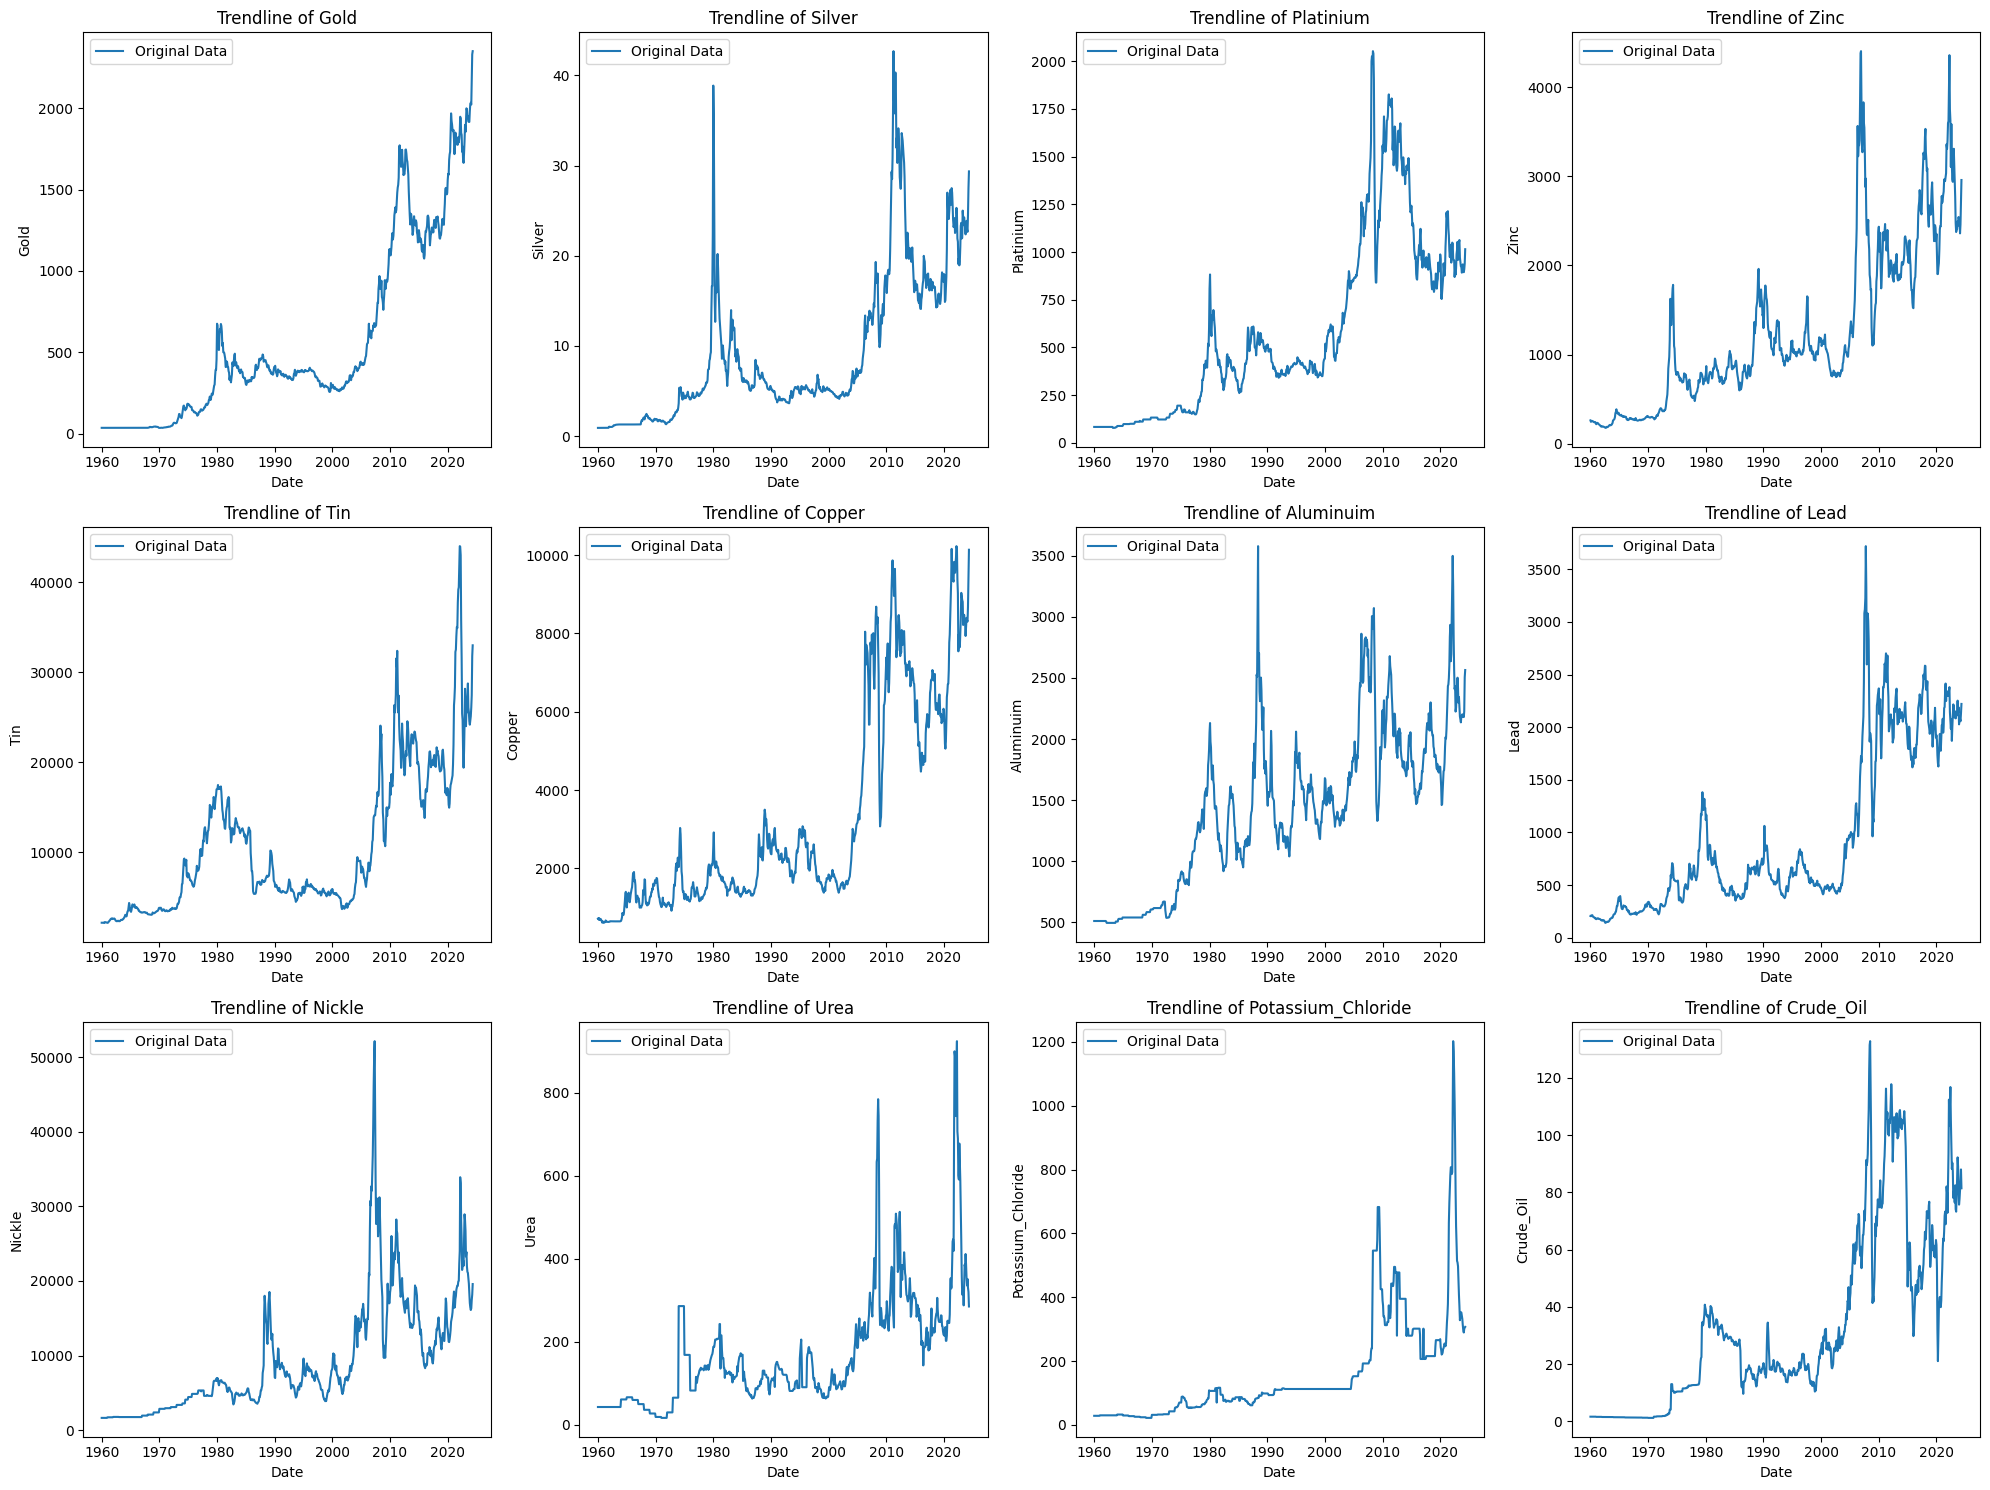

In [49]:
num_column = len(df.columns)
num_row_per_plot = 4
num_row = (num_column + num_row_per_plot - 1) // num_row_per_plot
fig, axes = plt.subplots(num_row, num_row_per_plot, figsize=(20, num_row * 5))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.lineplot(ax=axes[i], x=df.index, y = df[column], label='Original Data')
    axes[i].set_title(f'Trendline of {column}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [50]:
# Returns
df_pct = df.pct_change()
df_pct = df_pct.dropna()
df_pct.head()

,Gold,Silver,Platinium,Zinc,Tin,Copper,Aluminuim,Lead,Nickle,Urea,Potassium_Chloride,Crude_Oil
Date,,,,,,,,,,,,
1960-02-01,0.0,0.0,0.0,-0.060966,0.000000,0.017878,0.0,-0.011645,0.0,0.0,0.0,0.0
1960-03-01,0.0,0.0,0.0,0.015517,-0.003027,-0.059394,0.0,0.032401,0.0,0.0,0.0,0.0
1960-04-01,0.0,0.0,0.0,0.023723,0.002024,0.055728,0.0,0.015692,0.0,0.0,0.0,0.0
1960-05-01,0.0,0.0,0.0,-0.003142,-0.007116,-0.053049,0.0,-0.000936,0.0,0.0,0.0,0.0
1960-06-01,0.0,0.0,0.0,-0.015760,0.010219,0.009989,0.0,-0.051546,0.0,0.0,0.0,0.0


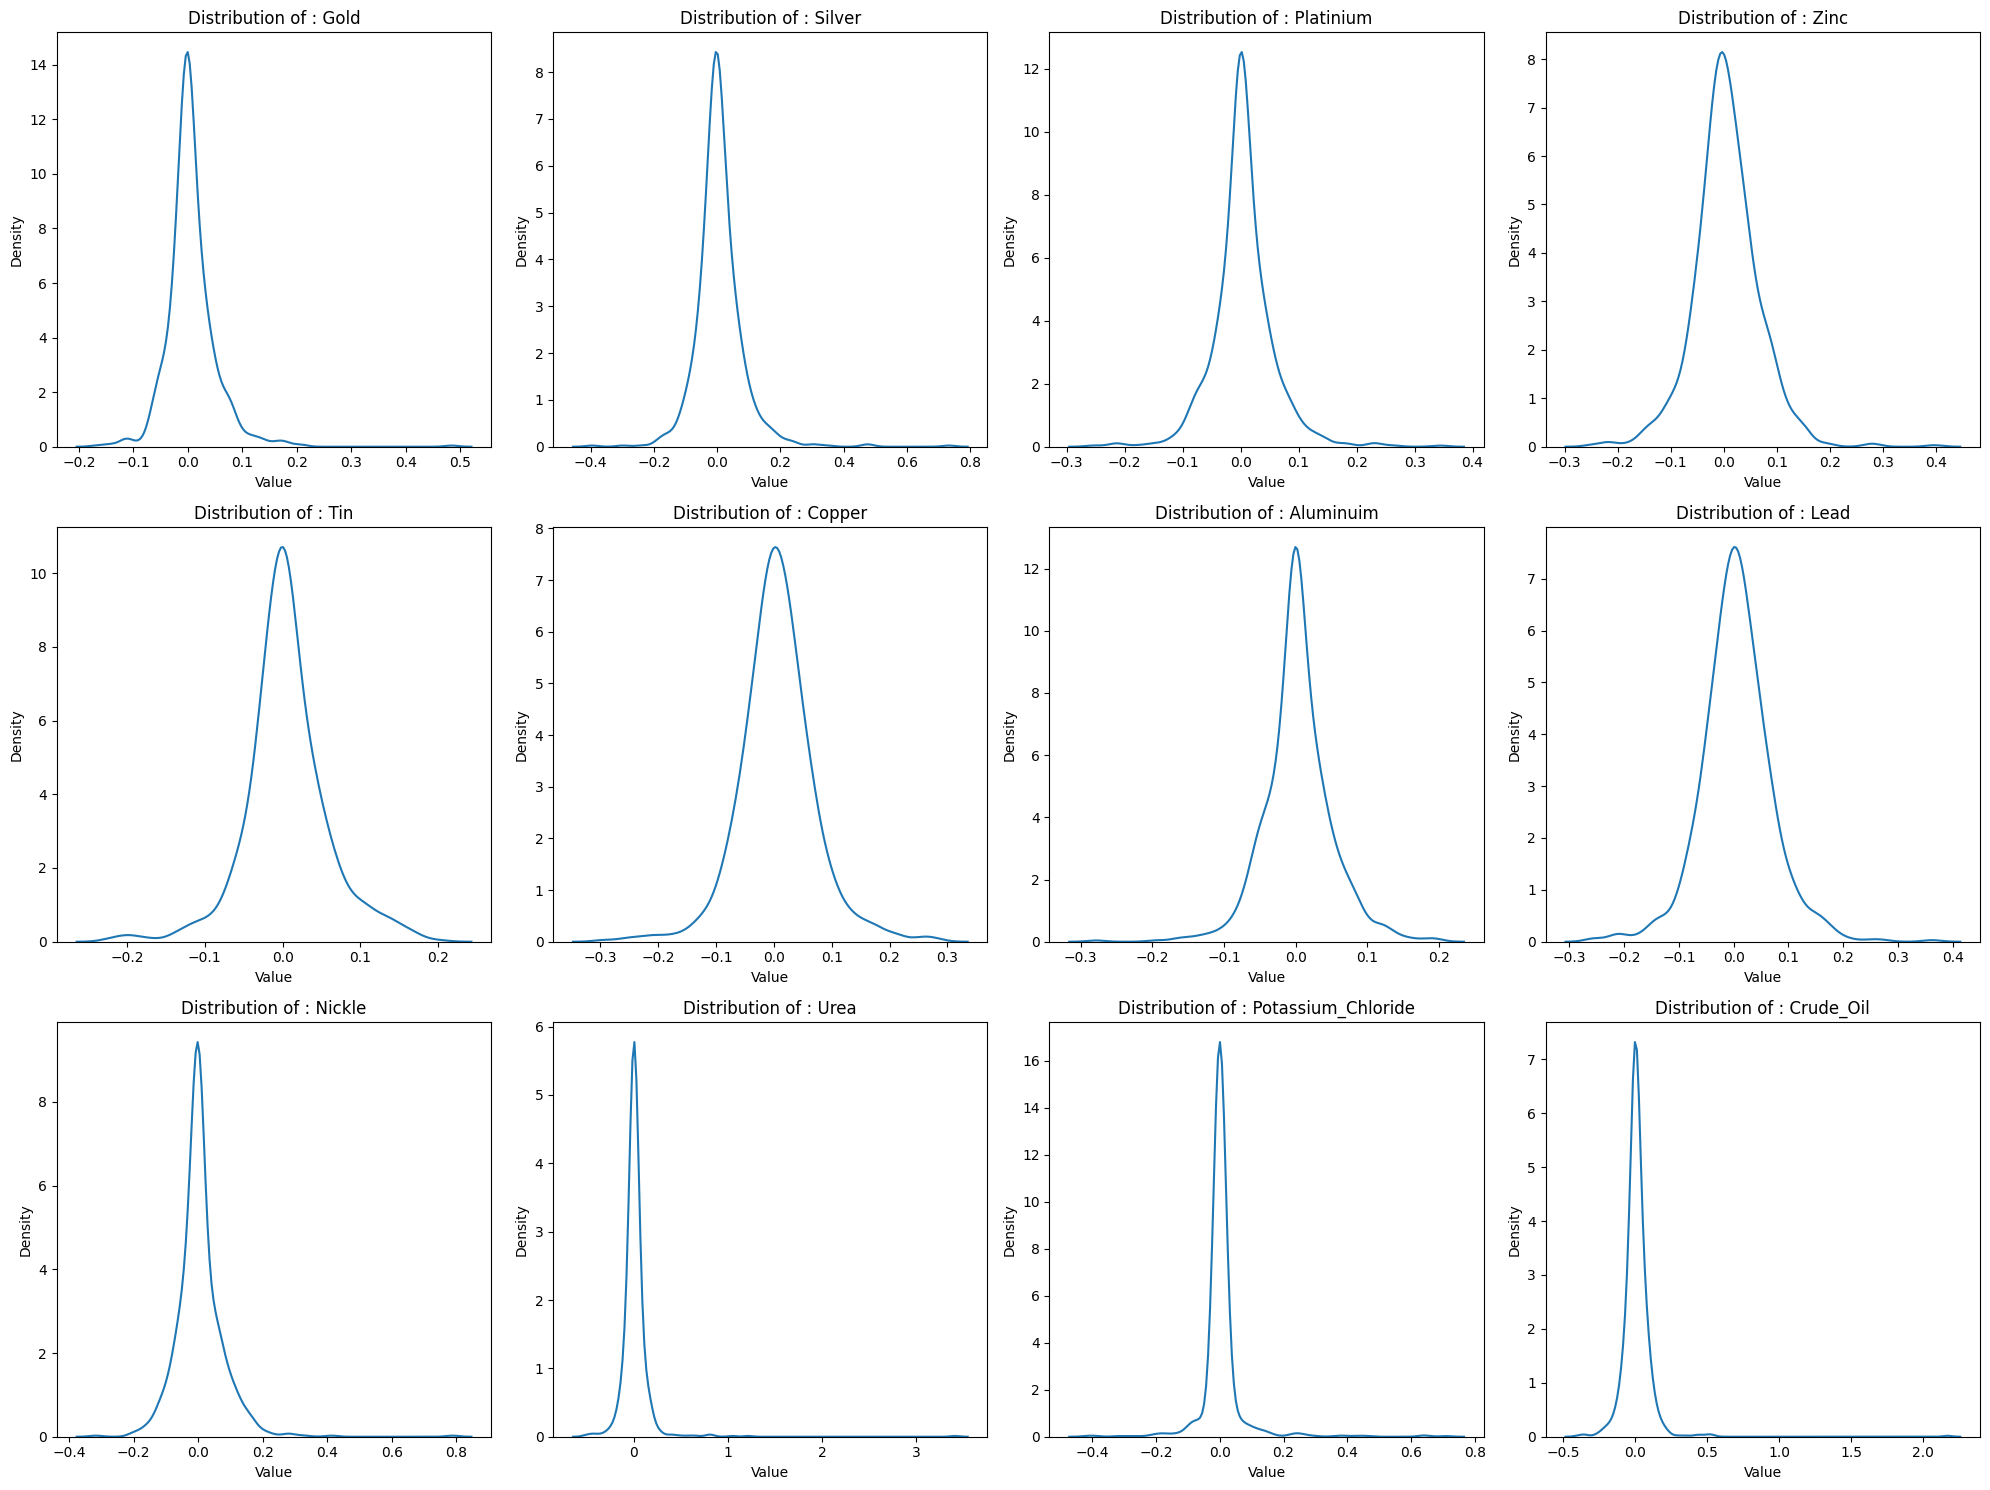

In [51]:
fig, axes = plt.subplots(num_row, num_row_per_plot, figsize=(20, num_row * 5))
axes = axes.flatten()
for i, column in enumerate(df_pct.columns):
    sns.kdeplot(df_pct[column], ax=axes[i])
    axes[i].set_title(f'Distribution of : {column}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

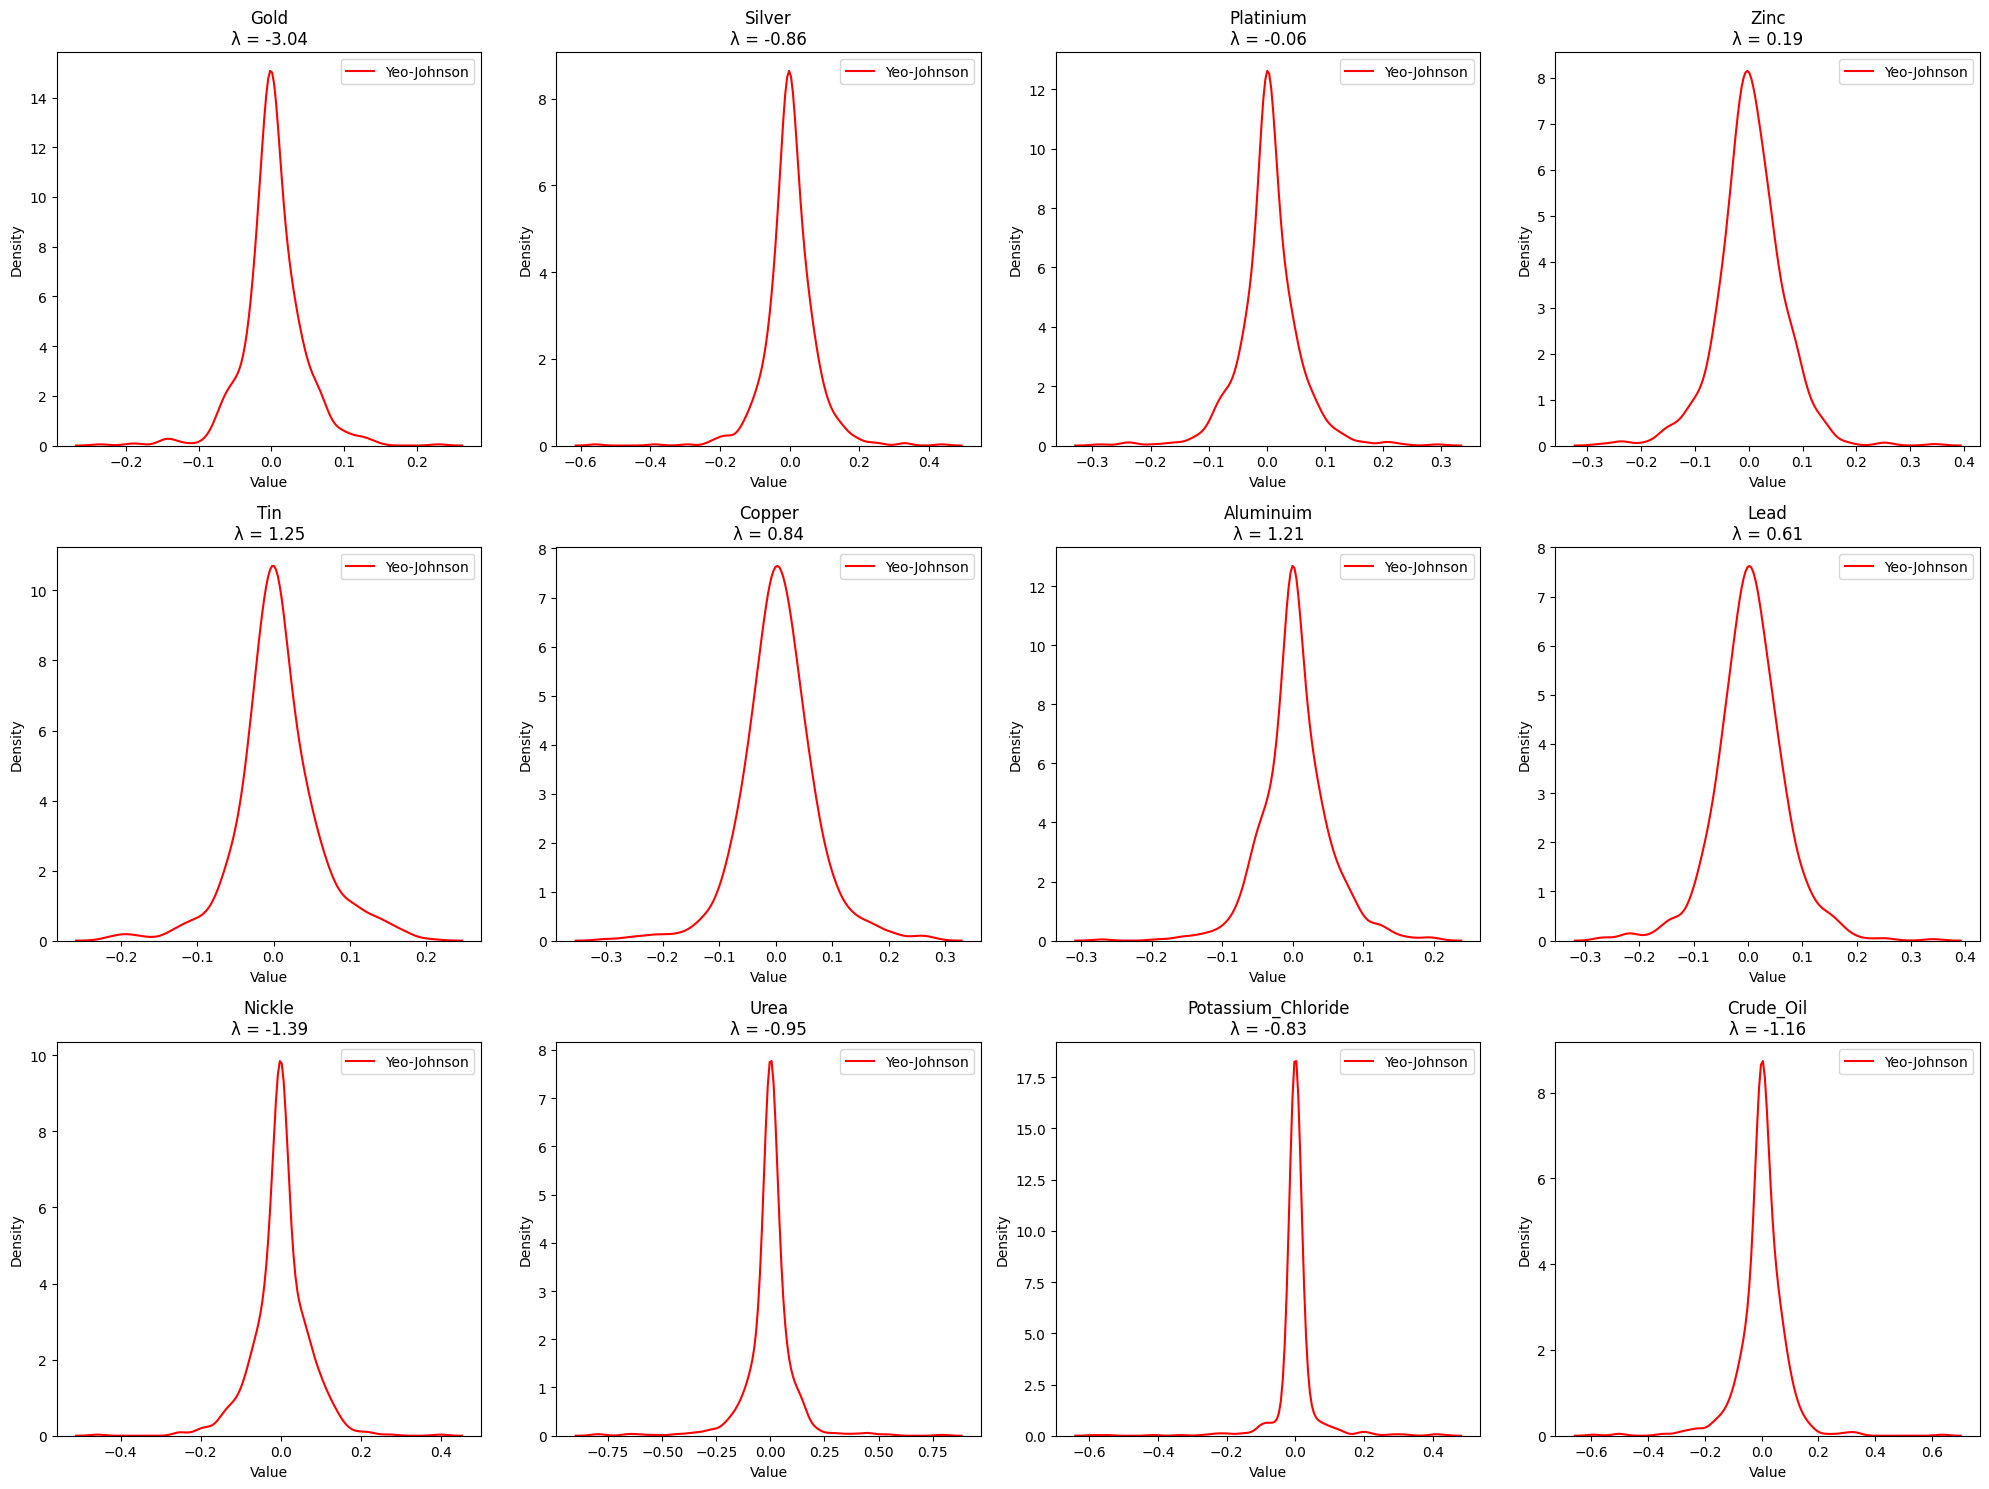

In [52]:
# Yeo-Johnson Transformation - To make distribution normal
from scipy import stats

fig, axes = plt.subplots(num_row, num_row_per_plot, figsize=(20, num_row * 5))
axes = axes.flatten()

for i, column in enumerate(df_pct.columns):
    transformed_data, lambda_param = stats.yeojohnson(df_pct[column])
    sns.kdeplot(transformed_data, ax=axes[i], color='red', label='Yeo-Johnson')
    axes[i].set_title(f'{column}\nλ = {lambda_param:.2f}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()
plt.tight_layout()
plt.show()

In [53]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
transformed_data = pt.fit_transform(df_pct)
df = pd.DataFrame(transformed_data, index = df_pct.index, columns=df_pct.columns)
df.head()

,Gold,Silver,Platinium,Zinc,Tin,Copper,Aluminuim,Lead,Nickle,Urea,Potassium_Chloride,Crude_Oil
Date,,,,,,,,,,,,
1960-02-01,-0.066527,-0.034803,-0.061613,-1.079917,-0.099402,0.191660,-0.072824,-0.249257,-0.001859,0.026838,-0.024143,-0.014715
1960-03-01,-0.066527,-0.034803,-0.061613,0.194032,-0.156136,-0.989402,-0.072824,0.431340,-0.001859,0.026838,-0.024143,-0.014715
1960-04-01,-0.066527,-0.034803,-0.061613,0.326161,-0.061440,0.764931,-0.072824,0.174496,-0.001859,0.026838,-0.024143,-0.014715
1960-05-01,-0.066527,-0.034803,-0.061613,-0.109628,-0.232708,-0.891881,-0.072824,-0.082732,-0.001859,0.026838,-0.024143,-0.014715
1960-06-01,-0.066527,-0.034803,-0.061613,-0.317593,0.092448,0.071742,-0.072824,-0.875719,-0.001859,0.026838,-0.024143,-0.014715


In [54]:
from sklearn.model_selection import train_test_split

X_col = ['Gold', 'Silver', 'Platinium', 'Zinc', 'Tin', 'Copper', 'Aluminuim', 'Lead', 'Nickle', 'Urea', 'Potassium_Chloride']
y_col = ['Crude_Oil']
X = df[X_col]
y = df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

print(f"Training MSE: {train_mse}")
print(f"Testing MSE: {test_mse}")

Training MSE: 0.8624280850556465
Testing MSE: 0.8405780922584577


The Training MSE and Testing MSE are quite close, indicating that the model is not overfitting and is likely generalizing well to unseen data. This suggests that the model has found a balance between fitting the training data and performing well on the test data.

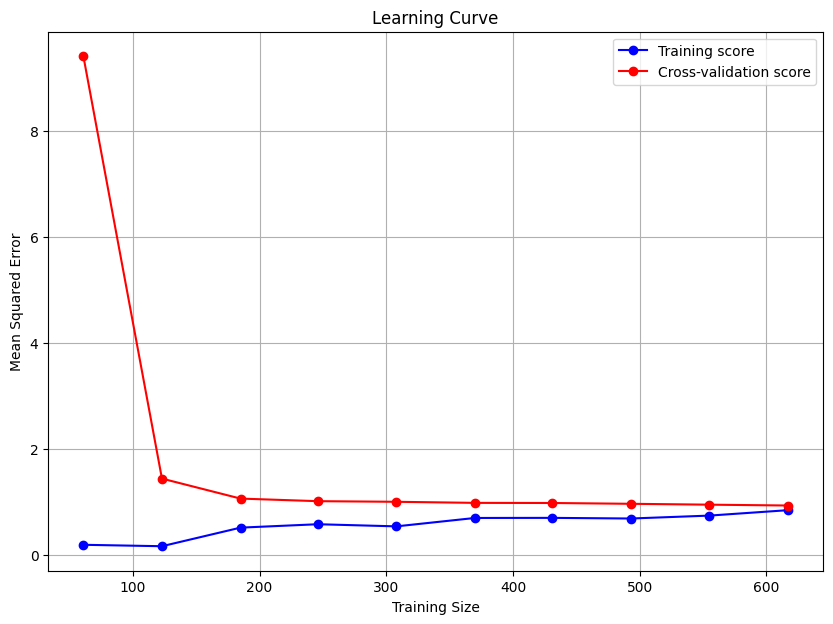

In [56]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1,1.0,10))
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Cross-validation score')
    plt.title('Learning Curve')
    plt.xlabel('Training Size')
    plt.ylabel('Mean Squared Error')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig('plot.png')
    plt.show()

plot_learning_curves(model, X, y)

In the learning curve, the training score shows a slight increase in mean square error as the training size increases, indicating that the model becomes slightly less accurate as it learns from more data but remains stable. The CV score starts with a high error, drops significantly as the training size increases, and then stabilizes, showing that the model improves with more data and eventually generalizes well. This suggests that the model initially overfits with a small training set, but as more data is added, it learns to generalize better, reducing overfitting.

In [57]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validation MSE: {-cv_scores.mean()}')

Cross-validation MSE: 0.935486630236339


The Cross-validation MSE of 0.935 indicates that the model's mean squared error on unseen data is relatively low, suggesting that the model is generalizing well across different subsets of the data and this low CV MSE implies that the model is not overfitting, as it performs consistently on both training and testing datasets.

In [58]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV

lambdas = [np.power(10, i) for i in np.arange(4, -4, -0.1)]
alphas = lambdas
ridge_cv = RidgeCV(alphas=alphas, cv=10, scoring="neg_mean_squared_error")
ridge_cv.fit(X_train, y_train)
ridge = Ridge(alpha=ridge_cv.alpha_, fit_intercept=True)
ridge.fit(X_train, y_train)
coef = ridge.coef_.reshape(-1, 1)
print(pd.DataFrame(coef, index=['Gold', 'Silver', 'Platinium', 'Zinc', 'Tin', 'Copper', 'Aluminuim', 'Lead', 'Nickle', 'Urea', 'Potassium_Chloride'], columns=['coef']))

                        coef
Gold                0.006645
Silver              0.036066
Platinium           0.090523
Zinc                0.014536
Tin                 0.072314
Copper              0.046988
Aluminuim           0.061935
Lead                0.010711
Nickle              0.062715
Urea                0.078886
Potassium_Chloride  0.039555


The coefficients from the Ridge regression indicate the strength and direction of the relationship between each commodity and Crude Oil prices. Higher coefficients, like those for Platinum, Tin, and Urea, suggest a stronger influence on Crude Oil, while lower coefficients, such as Lead and Zinc, indicate a weaker impact, all while accounting for potential multicollinearity among the predictors.

In [59]:
from sklearn.metrics import r2_score

ridge_pred = ridge.predict(X_test)
mse = mean_squared_error(y_test, ridge_pred)
r2 = r2_score(y_test, ridge_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.8568594288285747
R-squared: 0.14060951475888006


The Mean Squared Error (MSE) of 0.857 suggests that the model has a moderate level of prediction error on the test data. The low R-squared value of 0.141 indicates that the model explains only a small portion of the variance in Crude Oil prices, suggesting no overfitting

In [60]:
# Lasson Regression
lambdas = [np.power(10, i) for i in np.arange(6, -6, -0.1)]
lasso_cv = LassoCV(alphas=lambdas, cv=10)
lasso_cv.fit(X_train, y_train)
lasso = Lasso(alpha=lasso_cv.alpha_, fit_intercept=True)
lasso.fit(X_train, y_train)
coef = lasso.coef_.reshape(-1,1)
print(pd.DataFrame(coef, index=['Gold', 'Silver', 'Platinium', 'Zinc', 'Tin', 'Copper', 'Aluminuim', 'Lead', 'Nickle', 'Urea', 'Platinium_Chloride'], columns=['coef']))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                        coef
Gold                0.000000
Silver              0.000000
Platinium           0.144552
Zinc                0.000000
Tin                 0.091695
Copper              0.045177
Aluminuim           0.065709
Lead                0.000000
Nickle              0.066337
Urea                0.102200
Platinium_Chloride  0.026710


The Lasso regression coefficients show that several variables, such as Gold, Silver, and Zinc, have been shrunk to zero, indicating they are not contributing to the prediction, which helps in reducing overfitting by enforcing sparsity. This suggests that Lasso has effectively selected only the most relevant predictors, like Platinum, Tin, and Urea, thereby simplifying the model and potentially improving generalization to new data.

In [61]:
lasso_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, lasso_pred)
r2 = r2_score(y_test, lasso_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.848006380551634
R-squared: 0.14948871384172657


The Mean Squared Error (MSE) of 0.848 for the Lasso regression indicates a moderate prediction error on the test data. The R-squared value of 0.149 suggests that the model explains a small portion of the variance in Crude Oil prices, which implies that, while Lasso has reduced overfitting by selecting fewer predictors

# **SKEWNESS**

## Demonstration

In [63]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from statsmodels.graphics.regressionplots import abline_plot
import scipy.stats as stats
from scipy.stats import kurtosis, skewnorm
from scipy.stats import iqr
from scipy.stats import skew
from pandas.core.common import random_state
from sklearn.linear_model import LinearRegression
import yfinance as yfin
import math


plt.rcParams["figure.figsize"] = (10, 7)

In [64]:
# Download the dataset of 5-year NASDAQ stock data from Yahoo finance
NQ = yfin.download('NQ=F', start='2019-01-01')[["Open","Low", "High","Adj Close"]]
NQ.head()


[*********************100%***********************]  1 of 1 completed


,Open,Low,High,Adj Close
Date,,,,
2019-01-02,6349.50,6154.00,6409.25,6371.00
2019-01-03,6242.75,6148.50,6304.25,6162.00
2019-01-04,6168.75,6136.50,6462.00,6434.00
2019-01-07,6451.25,6402.50,6535.75,6496.50
2019-01-08,6506.00,6467.25,6586.25,6557.25


In [65]:
# Resample dataset into Monthly returns
data = NQ['Adj Close'].resample('M').last().pct_change().dropna()
data.head()

,Adj Close
Date,
2019-02-28,0.027152
2019-03-31,0.041957
2019-04-30,0.053983
2019-05-31,-0.085449
2019-06-30,0.078538


In [66]:
data.describe()

,Adj Close
count,67.000000
mean,0.017395
std,0.061241
min,-0.135637
25%,-0.021775
50%,0.027152
75%,0.059740
max,0.154407


## Diagram

In [67]:
data = pd.DataFrame(data, columns=['Adj Close'])
data.head()

,Adj Close
Date,
2019-02-28,0.027152
2019-03-31,0.041957
2019-04-30,0.053983
2019-05-31,-0.085449
2019-06-30,0.078538


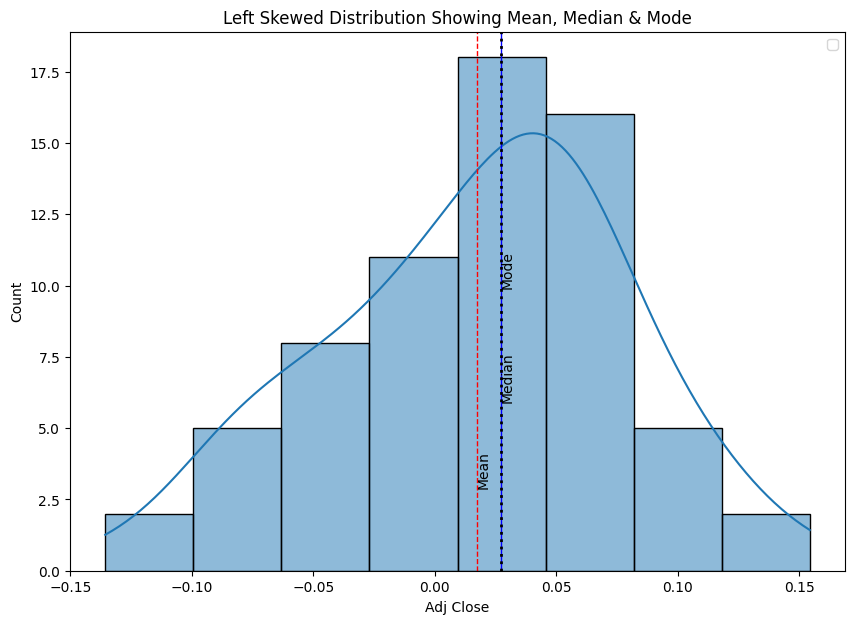

In [69]:
# Create a Histplot
sns.histplot(data=data, x='Adj Close', kde=True)

 # Add Mean
plt.axvline(data['Adj Close'].mean(), color='r', linestyle='dashed', linewidth=1)
plt.text(data['Adj Close'].mean(), 3, "Mean", rotation=90)
  # Add Median
plt.axvline(data['Adj Close'].median(), color='b',linestyle='solid',  linewidth=1)
plt.text(data['Adj Close'].median(), 6, "Median", rotation=90)

  # Add Mode
plt.axvline(data['Adj Close'].value_counts().idxmax(), color='black', linestyle='dotted', linewidth=2)
plt.text(data['Adj Close'].value_counts().idxmax(), 10, "Mode", rotation=90)

plt.title("Left Skewed Distribution Showing Mean, Median & Mode")
plt.legend()


plt.show()

In [70]:
data.median()

,0
Adj Close,0.027152


## Diagnosis

To diagnose the challenge of Skewness, the Skewness test is executed on the dataset

### Skewness test

In [72]:
# Skewness
skew(data['Adj Close'])

-0.28337836696506863

Skewness is a measure of a distribution's symmetry or more precisely lack of symmetry. The data distribution is left-skewed since a negative value(-0.2833) was obtained from the skewness test.

